## Imports and Constants

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#%tensorflow_version 1.x
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from collections import defaultdict
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from batchers import batcher, dataset_constants, tfrecord_paths_utils
from models.histograms import (
    get_per_image_histograms,
    plot_band_hists,
    plot_label_hist,
    split_nl_hist)
from utils.general import load_npz
from utils.plot import scatter_preds


In [ ]:
# BAND_BIN_EDGES = [-10^5, -5.0, -4.9, -4.8, ..., 4.8, 4.9, 5.0, 10^5]
# BAND_BIN_CENTERS = [-5.05, -4.95, -4.85, ..., 4.85, 4.95, 5.05]

BAND_BIN_EDGES = np.concatenate([
    [-1e5],
    np.arange(-5.0, 5.1, 0.1),
    [1e5]
])
BAND_BIN_CENTERS = np.arange(-5.05, 5.15, 0.1)

# LABEL_BIN_EDGES = [-2.0, -1.9, ..., 2.8, 2.9]
# LABEL_BIN_CENTERS = [-1.95, -1.85, ..., 2.75, 2.85]
LABEL_BIN_EDGES = np.arange(-2.0, 3.0, 0.1)
LABEL_BIN_CENTERS = np.arange(-1.95, 2.95, 0.1)

# band name => color for plotting
BAND_COLORS = {
    'BLUE'  : 'blue',
    'GREEN' : 'green',
    'RED'   : 'red',
    'SWIR1' : 'purple',
    'SWIR2' : 'brown',
    'TEMP1' : 'orange',
    'NIR'   : 'pink',
    'NIGHTLIGHTS': 'black',
    'DMSP'  : 'black',
    'VIIRS' : 'gray',
}
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
BAND_ORDER_NLSPLIT = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'DMSP', 'VIIRS']

BANDS_DICT = {
    'rgb': [0, 1, 2],
    'rgbnl': [0, 1, 2, 7, 8],
    'ms': [0, 1, 2, 3, 4, 5, 6],
    'msnl': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'nl': [7, 8],
}

## Load histograms (or create if needed)

In [ ]:
def get_batcher(tfrecord_paths):
  iter_init, batch_op = batcher.Batcher(
        tfrecord_files= tfrecord_paths,
        label_name='IncomeIDHM',
        ls_bands='ms',
        nl_band='merge',
        batch_size=128,
        shuffle=False,
        augment=False,
        clipneg=False,
        normalize='IDHM').get_batch()
  return iter_init, batch_op

In [ ]:
file_path = 'income_image_hists.npz'

if not os.path.exists(file_path):
    # THIS REQUIRES >= 35 GB RAM
    tfrecord_paths = tfrecord_paths_utils.idhm()
    init_iter, batch_op = get_batcher(tfrecord_paths)
    results = get_per_image_histograms(init_iter, batch_op, band_bin_edges=BAND_BIN_EDGES)
    print('Saving image histograms to', file_path)
    np.savez_compressed(file_path, **results)


Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished batch 10
Finished batch 11
Finished batch 12
Finished batch 13
Finished batch 14
Finished batch 15
Finished batch 16
Finished batch 17
Finished batch 18
Finished batch 19
Finished batch 20
Finished batch 21
Finished batch 22
Finished batch 23
Finished batch 24
Finished batch 25
Finished batch 26
Finished batch 27
Finished batch 28
Finished batch 29
Finished batch 30
Finished batch 31
Finished batch 32
Finished batch 33
Finished batch 34
Finished batch 35
Finished batch 36
Finished batch 37
Finished batch 38
Finished batch 39
Finished batch 40
Finished batch 41
Finished batch 42
Finished batch 43
Finished batch 44
Finished batch 45
Finished batch 46
Finished batch 47
Finished batch 48
Finished batch 49
Finished batch 50
Finished batch 51
Finished batch 52
Finished batch 53
Finished batch 54
Finished batch 55
Finished batch 56
F

In [ ]:
result = load_npz(file_path)
image_hists = result['image_hists']
labels = result['labels']
locs = result['locs']
years = result['years']
nls_center = result['nls_center']
nls_mean = result['nls_mean']

dmsp_mask = years < 2012
viirs_mask = ~dmsp_mask

image_hists: dtype=int64, shape=(9748, 8, 102)
labels: dtype=float32, shape=(9748,)
locs: dtype=float32, shape=(9748, 2)
years: dtype=int32, shape=(9748,)
nls_center: dtype=float32, shape=(9748,)
nls_mean: dtype=float32, shape=(9748,)


## Split NL band

In [ ]:
# split NL band
image_hists = split_nl_hist(image_hists, years)

## Plot histograms


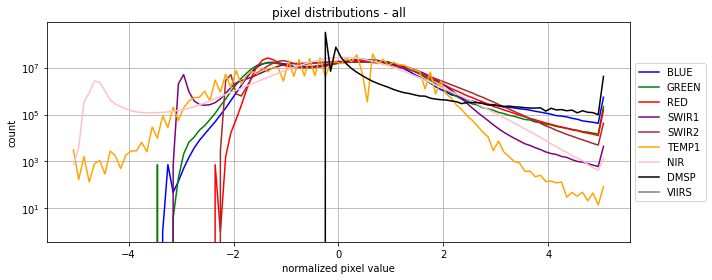

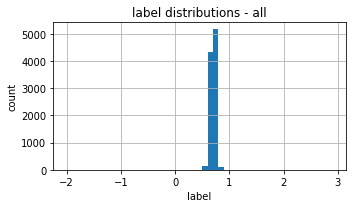

In [ ]:
band_hists = np.sum(image_hists, axis=0, dtype=np.int64)  # shape [C, nbins]
plot_band_hists(
    band_hists,
    BAND_ORDER_NLSPLIT,
    band_colors=BAND_COLORS,
    bin_centers=BAND_BIN_CENTERS,
    xlabel='normalized pixel value',
    ylabel='count',
    title='pixel distributions - all',
    yscale='log')
plot_label_hist(
    labels=labels,
    bin_edges=LABEL_BIN_EDGES,
    title='label distributions - all',
    figsize=(5, 3))